# Réseau Neuronal Convolutif (CNN)

Votre entreprise souhaite améliorer sa plateforme avec une nouvelle fonctionnalité de collaboration. Les utilisateurs pourront par exemple poster des avis et des photos sur leur restaurant préféré. Ce sera aussi l’occasion, pour l’entreprise, de mieux comprendre les avis postés par les utilisateurs.

**Objectif** : Labelliser automatiquement les photos postées sur la plateforme. Par exemple, identifier les photos relatives à la nourriture, au décor dans le restaurant ou à l’extérieur du restaurant.

# Sommaire

 1. [Chargement des bibliothèques](#load-lib)
 2. [Chargement des données](#load-data)
	1. [Sélection d'un échantillon](#select-sample)
    2. [Création des data frame](#create-df)
 3. [Préparation des données](#prepare-photos)
 4. [Définition du modèle](#cnn-model)
 5. [Entrainement du modèle](#train-model)
 6. [Performances du modèle](#pref-model)
 7. [Prédictions](#predict)
 8. [Conclusion](#conclusion)

# Chargement des bibliothèques <a class="anchor" id="load_lib"></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD
from keras_preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
from sklearn import cluster, metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.image import imread

Using TensorFlow backend.


In [2]:
datafile = '../data/photos.json'
img_dir = '../data/photos/'
img_clean_dir = '../data/clean_photos/'
outputfile = '../data/clean_photos.csv'
outputfile_raw = '../data/raw_photos.csv'
chunksize = 10000

# Chargement des données <a class="anchor" id="load_data"></a>

In [3]:
# Load data
data = pd.read_csv('../data/clean_photos.csv')
data.head()

,photo_id,label
0,Un_Og6jfhazVn7CxszkKEw,drink
1,BFE1AFOs27scnnfeBf99ZA,drink
2,7t-C0r1JRdoVD9FS7M-N7Q,drink
3,rLnw0d-YYZvT9kR4y7h7_Q,drink
4,Cv5M8MDw8a5NEWvw2AQ4nw,drink


## Sélection d'un échantillon <a class="anchor" id="select_sample"></a>
Nous allons sélectionner un échantillon de données équivalent dans chaque categories. Nous utiliserons 5000 images au total qui seront réparties en 3500 images pour l'entrainement, 900 images pour la validation et 600 images pour les tests.

In [4]:
n_sample = 1000
df_drink = data[data['label'] == 'drink'].sample(n=n_sample)
df_menu = data[data['label'] == 'menu'].sample(n=n_sample)
df_interior = data[data['label'] == 'interior'].sample(n=n_sample)
df_outside = data[data['label'] == 'outside'].sample(n=n_sample)
df_food = data[data['label'] == 'food'].sample(n=n_sample)

data = pd.concat([df_drink, df_menu, df_interior,df_outside, df_food ], ignore_index=True)

In [5]:
data['photo_id'] = data['photo_id'].apply(lambda x: x + '.jpg')

## Création  des data frame (train, val et test) <a class="anchor" id="load_lib"></a>

In [6]:
# Set train and val/test set
X_train, X_test, y_train, y_test = train_test_split(data['photo_id'], data['label'], test_size=0.30, random_state=63)

In [7]:
# Set val and test set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.40, random_state=63)

In [8]:
print(f"{X_train.shape} images pour l'entrainement")
print(f"{X_val.shape} images pour la validation")
print(f"{X_test.shape} images pour les test")

(3500,) images pour l'entrainement
(900,) images pour la validation
(600,) images pour les test


In [9]:
# Set train, val and test data frame
train_df = pd.DataFrame({ 'photo_id': X_train, 'label': y_train })
val_df = pd.DataFrame({ 'photo_id': X_val, 'label': y_val })
test_df = pd.DataFrame({ 'photo_id': X_test, 'label': y_test })

# Préparation des images <a class="anchor" id="prepare-photos"></a>
La préparation des images consiste à normaliser les images au niveau des pixels et à fixer leur dimensions (224x224 pixels)

In [10]:
batch_size=64
img_size=(224,224)

In [11]:
# ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [12]:
train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=img_dir,
            x_col="photo_id",
            y_col="label",
            has_ext=True,      
            image_size=img_size,
            batch_size=batch_size,
            seed=63,
            shuffle=True,
            class_mode="categorical",
            classes=['drink', 'menu', 'interior', 'outside', 'food'],
            target_size=(img_size))

Found 3500 validated image filenames belonging to 5 classes.


In [13]:
val_generator = val_datagen.flow_from_dataframe(
            dataframe=val_df,
            directory=img_dir,
            x_col="photo_id",
            y_col="label",
            has_ext=True,      
            image_size=img_size,
            batch_size=batch_size,
            seed=63,
            shuffle=True,
            class_mode="categorical",
            classes=['drink', 'menu', 'interior', 'outside', 'food'],
            target_size=(img_size))

Found 900 validated image filenames belonging to 5 classes.


In [14]:
test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=img_dir,
            x_col="photo_id",
            y_col="label",
            has_ext=True,            
            batch_size=test_df.shape[0],
            image_size=img_size,
            seed=63,
            shuffle=False,
            class_mode="categorical",
            classes=['drink', 'menu', 'interior', 'outside', 'food'],
            target_size=(img_size))

Found 600 validated image filenames belonging to 5 classes.


# Définition du modèle <a class="anchor" id="cnn-model"></a>
Nous avons choisi un réseau à convolution, car on obtient de bonnes performances sur les images, celui-ci est constitué de 3 blocs de 3 couches. Chaque bloc est constitué de :
 1. Une couche de convolution (32 filtres) de 3x3 (Conv2D)
 2. Une couche de réduction de la taille des images (MaxPooling)
 3. Couche de mise à zéro aléatoire de valeurs (dropout)

En fin le dernier bloc va effectuer les opérations suivantes : 
 1. Vectorisation
 2. Création d'une couche de sortie avec les 5 categories


In [15]:
opt = SGD(lr=0.001, momentum=0.9)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(5, activation='softmax')) # meilleur pour plus de 2 categories
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       7

# Entrainement du modèle <a class="anchor" id="train-model"></a>
Pour l'entraienment du modèle nous avons choisi d'entrainer 100 fois les données avec une mise à jour de 109 fois par époque pour le jeu d'entrainement et de 28 fois pour le jeu de validation. 

In [16]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL=val_generator.n//val_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

nb_epoch = 100

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=nb_epoch
)

Epoch 1/100
54/54 [==============================] - 110s 2s/step - loss: 6.2972 - accuracy: 0.2925 - val_loss: 1.5016 - val_accuracy: 0.4208
Epoch 2/100
54/54 [==============================] - 108s 2s/step - loss: 1.2977 - accuracy: 0.4869 - val_loss: 1.3276 - val_accuracy: 0.4766
Epoch 3/100
54/54 [==============================] - 109s 2s/step - loss: 1.1631 - accuracy: 0.5568 - val_loss: 1.2440 - val_accuracy: 0.4989
Epoch 4/100
54/54 [==============================] - 108s 2s/step - loss: 1.0956 - accuracy: 0.5859 - val_loss: 1.1817 - val_accuracy: 0.5424
Epoch 5/100
54/54 [==============================] - 108s 2s/step - loss: 1.0408 - accuracy: 0.6228 - val_loss: 1.1659 - val_accuracy: 0.5491
Epoch 6/100
54/54 [==============================] - 108s 2s/step - loss: 1.0096 - accuracy: 0.6359 - val_loss: 1.0997 - val_accuracy: 0.5770
Epoch 7/100
54/54 [==============================] - 107s 2s/step - loss: 0.9649 - accuracy: 0.6400 - val_loss: 1.0788 - val_accuracy: 0.5848
Epoch 

54/54 [==============================] - 108s 2s/step - loss: 0.0696 - accuracy: 0.9825 - val_loss: 1.2871 - val_accuracy: 0.6596
Epoch 61/100
54/54 [==============================] - 108s 2s/step - loss: 0.0686 - accuracy: 0.9814 - val_loss: 1.2711 - val_accuracy: 0.6551
Epoch 62/100
54/54 [==============================] - 108s 2s/step - loss: 0.0710 - accuracy: 0.9799 - val_loss: 1.2765 - val_accuracy: 0.6685
Epoch 63/100
54/54 [==============================] - 109s 2s/step - loss: 0.0589 - accuracy: 0.9881 - val_loss: 1.3012 - val_accuracy: 0.6540
Epoch 64/100
54/54 [==============================] - 108s 2s/step - loss: 0.0544 - accuracy: 0.9886 - val_loss: 1.3035 - val_accuracy: 0.6685
Epoch 65/100
54/54 [==============================] - 108s 2s/step - loss: 0.0694 - accuracy: 0.9822 - val_loss: 1.2943 - val_accuracy: 0.6763
Epoch 66/100
54/54 [==============================] - 108s 2s/step - loss: 0.0559 - accuracy: 0.9884 - val_loss: 1.2838 - val_accuracy: 0.6674
Epoch 67/100

In [17]:
# Save model
model.save("cnn_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cnn_model/assets


## Performances du modèle <a class="anchor" id="pref_model"></a>

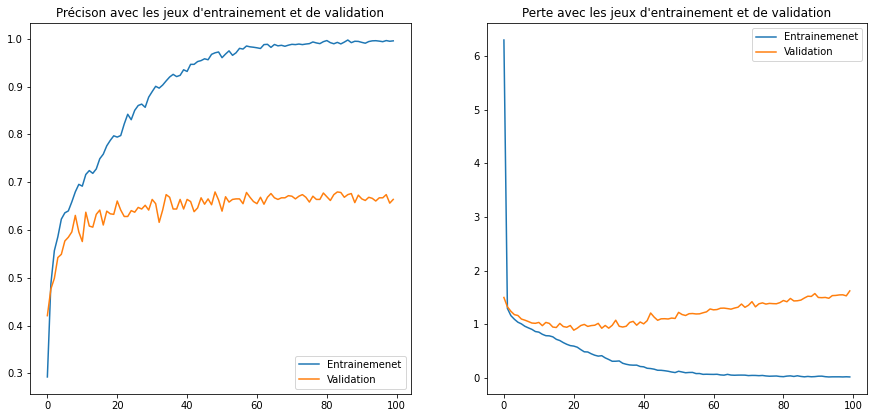

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(nb_epoch)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label="Entrainemenet")
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title("Précison avec les jeux d'entrainement et de validation")

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Entrainemenet')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc='upper right')
plt.title("Perte avec les jeux d'entrainement et de validation")
plt.show()

# Prédictions
Le jeu de données de test, va nous permettre de tester notre modèle avec des données complètement nouvelles pour le modèle.

In [19]:
test_generator.reset()
pred = model.predict(test_generator,verbose=1)

1/1 [==============================] - 0s 782us/step


In [20]:
_, acc = model.evaluate(test_generator, steps=len(test_generator), verbose=0)
print(f'La précision estimée est de  {acc * 100.0:.3f} %')

La précision estimée est de  68.833 %


In [21]:
predictions=[]
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
for row in pred:
    index = row.argmax()       
    predictions.append(labels[index])

filenames=test_generator.filenames

results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions,
                      "labels": test_generator.labels
                     })

In [22]:
results['labels'] = results['labels'].map(labels)

In [25]:
conf_mat = metrics.confusion_matrix(results['Predictions'], results['labels'])
display(conf_mat)

array([[ 79,  21,  28,   3,  20],
       [ 21, 103,  16,   3,   6],
       [ 10,   4,  67,   6,  16],
       [  1,   0,   6,  92,   3],
       [  6,   2,  12,   3,  72]])

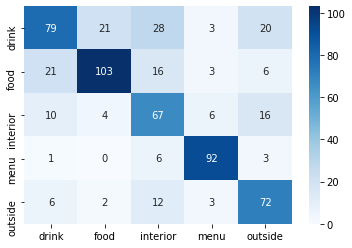

In [26]:
inv_labels = {v: k for k, v in labels.items()}
df_cm = pd.DataFrame(conf_mat, index = [label for label in inv_labels],columns = inv_labels)
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

# Conclusion <a class="anchor" id="conclusion"></a>
Ce modèle avec une précision de 65% montre de meilleures performances que le modèle à base SIFT, cependant il reste encore de nombreuses erreurs. L'avantage sur SIFT est aussi dû au fait que ce soit un algorithme supervisé

Une solution pourrait consister à prendre encore plus d'image et/ou d'augmenter le nombre de couches. 